In [1]:
import numpy as np
import xarray as xr
import sys, os
sys.path.insert(0, os.path.abspath('/Users/gmaze/git/github/gmaze/pyxpcm'))

Basic example with gridded products
===================================

Ocean profiles are not solely taken from a collection of pointwise observations, they can also come from a nicely gridded product. In this case, profiles are assembled along latitude and longitude grids, also possibly along different times. With Xarray_ it is quite simple to manipulate these data to work with PCM.

Load a dataset
--------------

Let's first load a dummy gridded dataset, a sub-domain over the Gulf Stream from the ISAS15_ product:

In [2]:
from pyxpcm import datasets as pcmdata
ds = pcmdata.load_isas15()
ds

<xarray.Dataset>
Dimensions:      (depth: 152, latitude: 53, longitude: 61)
Coordinates:
  * latitude     (latitude) float32 30.023445 30.455408 ... 49.41288 49.737103
  * longitude    (longitude) float32 -70.0 -69.5 -69.0 ... -41.0 -40.5 -40.0
  * depth        (depth) float32 -1.0 -3.0 -5.0 ... -1960.0 -1980.0 -2000.0
Data variables:
    TEMP         (depth, latitude, longitude) float32 24.458 ... 3.4309998
    TEMP_ERR     (depth, latitude, longitude) float32 0.33 0.328 ... 0.049000002
    TEMP_PCTVAR  (depth, latitude, longitude) float32 31.0 31.0 ... 99.0 99.0
    PSAL         (depth, latitude, longitude) float32 36.632 36.658 ... 34.917
    PSAL_ERR     (depth, latitude, longitude) float32 0.051000003 ... 0.006
    PSAL_PCTVAR  (depth, latitude, longitude) float32 32.0 32.0 ... 99.0 99.0
    SST          (latitude, longitude) float32 24.458 24.448 ... 13.216999

Let's look at surface temperature values:

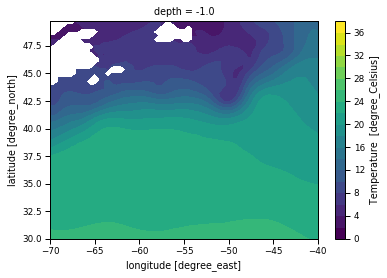

In [3]:
ds['TEMP'].isel(depth=0).plot.contourf(levels=np.arange(0,40,2))

Create a PCM
------------

Note that a Profile Classification Model (PCM) can be created independently of any dataset properties using the :class:`pyxpcm.pcm` class constructor.
But to keep things simple, here we will use the dataset vertical axis down to -800m depth and set it to use temperature data directly from the ``TEMP`` variable.

In [4]:
from pyxpcm.models import pcm

# Create the pcm
m = pcm(K=4, features={'TEMP': ds['depth'].where(ds['depth']>=-800, drop=True)})
m

<pcm 'gmm' (K: 4, F: 1)>
Number of class: 4
Number of feature: 1
Feature names: odict_keys(['TEMP'])
Fitted: False
Feature: 'TEMP'
	 Interpoler: <class 'pyxpcm.models.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing.data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition.pca.PCA'>
Classifier: 'gmm', <class 'sklearn.mixture.gaussian_mixture.GaussianMixture'>

Fit the PCM on the dataset
--------------------------

### Masking

In order to create a PCM from temperature profiles of this gridded product, pyXpcm will automatically mask the domain where features are not available on the PCM axis. This is done internally, but you can have access to the mask through the ``mask`` method:

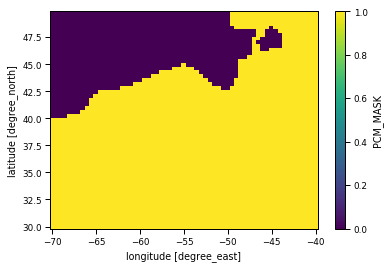

In [5]:
mask = ds.pyxpcm.mask(m, dim='depth')
mask.plot()

### Training

Now that we have a proper collection of profiles and a PCM, we can simply *fit* the classifier:

In [6]:
ds.pyxpcm.fit(m, dim='depth')

<pcm 'gmm' (K: 4, F: 1)>
Number of class: 4
Number of feature: 1
Feature names: odict_keys(['TEMP'])
Fitted: True
Feature: 'TEMP'
	 Interpoler: <class 'pyxpcm.models.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing.data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition.pca.PCA'>
Classifier: 'gmm', <class 'sklearn.mixture.gaussian_mixture.GaussianMixture'>
	 log likelihood of the training set: 18.837408

or equivalently:

In [7]:
m.fit(ds, dim='depth')

<pcm 'gmm' (K: 4, F: 1)>
Number of class: 4
Number of feature: 1
Feature names: odict_keys(['TEMP'])
Fitted: True
Feature: 'TEMP'
	 Interpoler: <class 'pyxpcm.models.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing.data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition.pca.PCA'>
Classifier: 'gmm', <class 'sklearn.mixture.gaussian_mixture.GaussianMixture'>
	 log likelihood of the training set: 18.837408

This PCM can now be used to classify any ocean profiles.

Classify ocean profiles
-----------------------

There are two methods to classify ocean profiles:

### Hard labelling

Once the PCM is trained, i.e. fitted with a training dataset, we can predict classes that profiles from a :class:`xarray.Dataset` belongs to. We can simply classify profile from the dataset that was used to fit the PCM:


In [8]:
LABELS = ds.pyxpcm.predict(m, dim='depth')
LABELS

<xarray.DataArray 'PCM_LABELS' (latitude: 53, longitude: 61)>
array([[ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       ...,
       [nan, nan, nan, ...,  0.,  0.,  0.],
       [nan, nan, nan, ...,  0.,  0.,  0.],
       [nan, nan, nan, ...,  0.,  0.,  0.]])
Coordinates:
  * latitude   (latitude) float64 30.02 30.46 30.89 31.31 ... 49.09 49.41 49.74
  * longitude  (longitude) float64 -70.0 -69.5 -69.0 -68.5 ... -41.0 -40.5 -40.0
Attributes:
    long_name:  PCM labels
    units:      
    valid_min:  0
    valid_max:  3
    llh:        18.837408448319763

Each profiles is labelled with one of the possible cluster index from 0 to K-1.

A map of labels can then be quickly drawn:

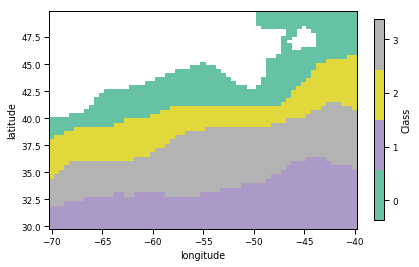

In [9]:
LABELS.plot(cmap=m.plot.cmap(), add_colorbar=False)
m.plot.colorbar()

Note that here we made use of the :class:`pyxpcm.plot` methods `cmap` and `colorbar` to produce appropriate colors for labels.

### Fuzzy classification

Since the PCM classifier we used (GMM) is fuzzy, we can also predict the probabilities for profiles to belong to each of the classes, the so-called posterior probabilities:

In [10]:
POSTERIORS = ds.pyxpcm.predict_proba(m, dim='depth')
POSTERIORS

<xarray.DataArray 'PCM_POST' (pcm_class: 4, latitude: 53, longitude: 61)>
array([[[4.346725e-211, 4.169528e-218, ..., 1.324114e-191, 1.086648e-188],
        [5.385217e-225, 1.127551e-228, ..., 1.782799e-190, 3.685586e-187],
        ...,
        [          nan,           nan, ..., 1.000000e+000, 1.000000e+000],
        [          nan,           nan, ..., 1.000000e+000, 1.000000e+000]],

       [[1.000000e+000, 1.000000e+000, ..., 1.000000e+000, 1.000000e+000],
        [1.000000e+000, 1.000000e+000, ..., 1.000000e+000, 1.000000e+000],
        ...,
        [          nan,           nan, ..., 0.000000e+000, 0.000000e+000],
        [          nan,           nan, ..., 0.000000e+000, 0.000000e+000]],

       [[3.616859e-233, 2.021647e-255, ..., 8.501288e-220, 7.394979e-214],
        [8.371489e-191, 5.925613e-213, ..., 1.968247e-232, 9.100335e-228],
        ...,
        [          nan,           nan, ..., 4.559768e-058, 2.020494e-057],
        [          nan,           nan, ..., 1.343549e-054,

which can then be map like:

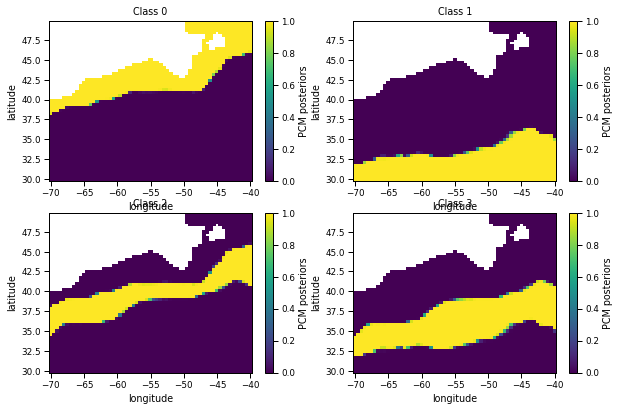

In [14]:
fig, ax = m.plot.subplots(figsize=(10,10), maxcols=2)
for k in m:
    POSTERIORS.sel(pcm_class=k).plot(ax=ax[k])
    ax[k].set_title("Class %i" % k)

Note here that we made use of the following pyXpcm useful tools:

- the :class:`pyxpcm.pcm` instance has an iterator on clusters, so we can use:

In [12]:
for k in m:
    print('This is class ', k)

This is class  0
This is class  1
This is class  2
This is class  3


- the :class:`pyxpcm.plot` has a ``subplots`` method to automatically create a figure with one subplot per class.

Summary
-------

You can look at in the [summary](summary.rst) page for an more an overview.

.. _ISAS15: https://doi.org/10.17882/52367
.. _Xarray: http://xarray.pydata.org/en/stable